In [1]:
from app import app, db, bcrypt
from models import User, Stock, Portfolio
from flask import jsonify, request
import pandas as pd
import sqlite3

import numpy as np
import statistics

In [2]:
data = [
  {
    "date": "Sat, 01 Mar 2025 00:00:00 GMT",
    "id": 2,
    "purchase_price": 1600.0,
    "quantity": 10,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Sat, 01 Feb 2025 00:00:00 GMT",
    "id": 3,
    "purchase_price": 2200.0,
    "quantity": 20,
    "symbol": "HINDUNILVR.NS"
  },
  {
    "date": "Tue, 04 Mar 2025 00:00:00 GMT",
    "id": 4,
    "purchase_price": 3500.0,
    "quantity": 30,
    "symbol": "TCS.NS"
  },
  {
    "date": "Fri, 04 Aug 2023 00:00:00 GMT",
    "id": 5,
    "purchase_price": 900.0,
    "quantity": 10,
    "symbol": "BBTC.NS"
  },
  {
    "date": "Sat, 01 Feb 2025 00:00:00 GMT",
    "id": 6,
    "purchase_price": 1200.0,
    "quantity": 20,
    "symbol": "BALKRISIND.NS"
  },
  {
    "date": "Tue, 10 Sep 2019 00:00:00 GMT",
    "id": 12,
    "purchase_price": 1400.0,
    "quantity": 90,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Wed, 19 May 2021 00:00:00 GMT",
    "id": 13,
    "purchase_price": 1500.0,
    "quantity": 30,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Wed, 08 Feb 2023 00:00:00 GMT",
    "id": 14,
    "purchase_price": 1450.0,
    "quantity": 70,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Wed, 08 Feb 2023 00:00:00 GMT",
    "id": 15,
    "purchase_price": 2450.0,
    "quantity": 70,
    "symbol": "HINDUNILVR.NS"
  },
  {
    "date": "Thu, 11 Mar 2021 00:00:00 GMT",
    "id": 16,
    "purchase_price": 2150.0,
    "quantity": 90,
    "symbol": "HINDUNILVR.NS"
  },
  {
    "date": "Wed, 10 Jul 2019 00:00:00 GMT",
    "id": 17,
    "purchase_price": 3000.0,
    "quantity": 60,
    "symbol": "TCS.NS"
  },
  {
    "date": "Tue, 11 Mar 2025 00:00:00 GMT",
    "id": 18,
    "purchase_price": 1400.0,
    "quantity": 40,
    "symbol": "BALKRISIND.NS"
  },
  {
    "date": "Tue, 11 Mar 2025 00:00:00 GMT",
    "id": 19,
    "purchase_price": 1400.0,
    "quantity": 40,
    "symbol": "BALKRISIND.NS"
  }
]


In [3]:
import sys
import json
import sqlite3
from datetime import datetime, date, timedelta

#data_input = sys.argv[1]

# start and end date
startDate = date.today() - timedelta(days=365)
endDate = date.today()

# Factory Pattern for Trade Creation
class Trade:
    def __init__(self, id, symbol, purchase_price, quantity, date):
        self.id = id
        self.symbol = symbol
        self.purchase_price = purchase_price
        self.quantity = quantity
        self.date = datetime.strptime(date, '%a, %d %b %Y %H:%M:%S %Z')

    def __str__(self):
        return f"Trade(symbol={self.symbol}, purchase_price={self.purchase_price})"

    def lastPrice(self):
        return PortfolioValueProvider().get_asset_value(self.symbol,"Close", startDate, endDate)

    def totalValueNew(self):
        return self.quantity * self.lastPrice()


class TradeFactory:
    def create_trade(self, id, symbol, purchase_price, quantity, date):
        return Trade(id, symbol, purchase_price, quantity, date)


# Portfolio Class with Aggregation and API Interaction
class Portfolio:
    def __init__(self):
        self.trades = []
        self.value_provider = PortfolioValueProvider()
        self.net_values = None  # Store the calculated net values
        self.portfolio_status = {}  # Store the portfolio's status for each date

    def add_trade(self, trade):
        self.trades.append(trade)
        self.update_portfolio_status()

    def add_trades(self, trade_data):
        trade_factory = TradeFactory()
        for trade_info in trade_data:
            self.trades.append(trade_factory.create_trade(**trade_info))
        self.update_portfolio_status()

    def calculate_net(self):
        if self.net_values is None:
            net_value = {}
            total_quantity = {}
            average_price = {}
            current_value = {}
            for trade in self.trades:
                if trade.symbol in net_value:
                    net_value[trade.symbol] += trade.quantity * trade.purchase_price
                    total_quantity[trade.symbol] += trade.quantity
                    average_price[trade.symbol] = net_value[trade.symbol] / total_quantity[trade.symbol]
                    current_value[trade.symbol] = total_quantity[trade.symbol] * self.value_provider.get_asset_value(
                        trade.symbol, "Close", startDate, endDate)
                else:
                    net_value[trade.symbol] = trade.quantity * trade.purchase_price
                    total_quantity[trade.symbol] = trade.quantity
                    average_price[trade.symbol] = net_value[trade.symbol] / total_quantity[trade.symbol]
                    current_value[trade.symbol] = total_quantity[trade.symbol] * self.value_provider.get_asset_value(
                        trade.symbol, "Close", startDate, endDate)
            self.net_values = net_value, total_quantity, average_price, current_value

        return self.net_values

    def calculate_current_value(self, currency):
        current_value = {}
        for trade in self.trades:
            currency_converter = 1
            asset_value = self.value_provider.get_asset_value(trade.symbol, "Close", startDate, trade.date)
            if asset_value is not None:
                current_value[trade.symbol] = asset_value * trade.quantity * currency_converter
        return current_value

    def update_portfolio_status(self):
        for trade in self.trades:
            if trade.date not in self.portfolio_status:
                self.portfolio_status[trade.date] = {}

            if trade.symbol not in self.portfolio_status[trade.date]:
                self.portfolio_status[trade.date][trade.symbol] = trade.quantity
            else:
                self.portfolio_status[trade.date][trade.symbol] += trade.quantity

    def get_portfolio_status_by_date(self, date):
        return self.portfolio_status.get(date, {})

    def get_portfolio_status_for_dates(self, dates):
        portfolio_status_for_dates = []

        for date in dates:
            portfolio_status_for_dates.append({
                'date': date,
                'assets_quantity': self.get_portfolio_status_by_date(date)
            })

        return portfolio_status_for_dates

    def calculate_daily_values_oneyear(self, currency):
        daily_values = []
        trade_dates = []
        stock_quantity = {}
        start_dt = startDate
        end_dt = endDate
        delta = timedelta(days=1)

        # store the dates between two dates in a list
        dates_oneyear = []

        while start_dt <= end_dt:
            dates_oneyear.append(start_dt.isoformat())
            start_dt += delta

        sorted_trades = sorted(self.trades, key=lambda trade: trade.date)
        for date in dates_oneyear:
            total_value_for_date = 0
            for trade in sorted_trades:
                if trade.date == date:
                    total_value_for_date += trade.quantity * self.value_provider.get_asset_value(trade.symbol, date)
            daily_values.append(total_value_for_date)

        portfolio_status = self.get_portfolio_status_for_dates(dates_oneyear)

        return portfolio_status, dates_oneyear

    def assets_on_dates_oneyear(self):
        dates_oneyear = []
        start_dt = startDate
        end_dt = endDate
        delta = timedelta(days=1)

        while start_dt <= end_dt:
            dates_oneyear.append(start_dt.isoformat())
            start_dt += delta

        assets_by_date = {}

        trade_dates_set = set(trade.date for trade in self.trades)
        sorted_trades = sorted(self.trades, key=lambda trade: trade.date)

        for date1 in dates_oneyear:
            assets_on_date = {}
            date1_dt = datetime.fromisoformat(date1)  # Convert date1 to datetime object
            for trade in self.trades:
                if trade.date <= date1_dt:
                    if trade.symbol in assets_on_date:
                        assets_on_date[trade.symbol] += trade.quantity
                    else:
                        assets_on_date[trade.symbol] = trade.quantity
            assets_by_date[date1] = assets_on_date

        return assets_by_date

    @staticmethod
    def portfolio_value_for_dates(portfolio_dict, currency):
        stock_data = {}
        value_provider = PortfolioValueProvider()
        #startDate = date.today() - timedelta(days=365)
        #endDate = date.today()

        for date_str, stocks in portfolio_dict.items():
            date_obj = datetime.strptime(date_str, '%Y-%m-%d').date()  # Convert date string to date object
            for stock_name in stocks.keys():
                if stock_name not in stock_data:
                    stock_data[stock_name] = value_provider.get_asset_values(stock_name, "Close", startDate, endDate)

        portfolio_value_by_dates = {}

        for date_str, stocks in portfolio_dict.items():
            # Convert date string to datetime object with time set to midnight
            date_obj = datetime.strptime(date_str, '%Y-%m-%d')
            date_key = date_obj.strftime('%Y-%m-%d %H:%M:%S')  # Format to match stock_history keys
            total_value = 0

            for stock_name, quantity in stocks.items():
                stock_history = stock_data[stock_name]

                if date_key in stock_history:
                    stock_value = stock_history[date_key] * quantity
                    total_value += stock_value

            if total_value > 0:
                portfolio_value_by_dates[date_str] = total_value
        return portfolio_value_by_dates

    def calculate_risk_metrics(self, price_array, portfolio_value):
            risk_metrics = RiskMetrics(price_array, portfolio_value)
            monte_carlo_var_dollar, simulated_returns = risk_metrics.monte_carlo_var()
            return {
                "mean": risk_metrics.mean(),
                "variance": risk_metrics.variance(),
                "std_dev": risk_metrics.standard_deviation(),
                "max": risk_metrics.max_price(),
                "min": risk_metrics.min_price(),
                "sharpe_ratio": risk_metrics.sharpe_ratio(),
                "sortino_ratio": risk_metrics.sortino_ratio(),
                "value_at_risk": risk_metrics.value_at_risk(),
                "value_at_risk_dollar": risk_metrics.value_at_risk_dollar(),
                "monte_carlo_var": monte_carlo_var_dollar,
                "monte_carlo_simulated_returns": simulated_returns.tolist(),  # For histogram
                "rolling_std_dev": risk_metrics.rolling_std_dev()  # For volatility chart
            }





# Data Collection
class PortfolioValueProvider:
    def __init__(self):
        self.conn = sqlite3.connect('stock_data.db')
        self.cursor = self.conn.cursor()


    def get_asset_value(self, symbol, metric, startDate, endDate):
        query = """
        SELECT d.value
        FROM Data d
        JOIN Companies c ON d.Company_ID = c.Company_ID
        JOIN Metrics m ON d.Metric_ID = m.Metric_ID
        WHERE c.company = ?
        AND m.metric = ?
        AND d.Date BETWEEN ? AND ?
        ORDER BY date DESC LIMIT 1
        """
        self.cursor.execute(query, (symbol, metric, startDate, endDate))
        result = self.cursor.fetchone()
        return result[0] if result else None

    def get_asset_values(self, symbol, metric, startDate, endDate):
        query = """
        SELECT d.Date, d.value
        FROM Data d
        JOIN Companies c ON d.Company_ID = c.Company_ID
        JOIN Metrics m ON d.Metric_ID = m.Metric_ID
        WHERE c.company = ?
        AND m.metric = ?
        AND d.Date BETWEEN ? AND ?
        ORDER BY d.date
        """
        self.cursor.execute(query, (symbol, metric, startDate, endDate))
        result = self.cursor.fetchall()
        return {row[0]: row[1] for row in result}  # Return a dictionary with dates as keys
        #return result
    #{row[0]: row[1] for row in result}

    @staticmethod
    def get_exchange_rate(country, target_currency='USD'):
        if country in PortfolioValueProvider.exchange_rates and target_currency in PortfolioValueProvider.exchange_rates[
            country]:
            return PortfolioValueProvider.exchange_rates[country][target_currency]
        else:
            return 1.0

    # Sample exchange rates (USD to other currencies)
    exchange_rates = {
        'USA': {
            'USD': 1.0,  # 1 USD to USD
            'INR': 75.0,  # Sample exchange rate: 1 USD to 75 INR
            'EUR': 0.85,  # Sample exchange rate: 1 USD to 0.85 EUR
        },
        'India': {
            'INR': 1.0,  # 1 INR to INR
            'USD': 0.013,  # Sample exchange rate: 1 INR to 0.013 USD
            'EUR': 0.011,  # Sample exchange rate: 1 INR to 0.011 EUR
        }
    }

# RiskMetrics Class for Financial Metrics
class RiskMetrics:
    def __init__(self, price_array, portfolio_value, risk_free_rate=0.02):
        self.price_array = price_array
        self.portfolio_value = portfolio_value  # Total portfolio value in dollars
        self.risk_free_rate = risk_free_rate

    def mean(self):
        return np.mean(self.price_array) if self.price_array else 0

    def variance(self):
        return np.var(self.price_array) if self.price_array else 0

    def standard_deviation(self):
        return np.std(self.price_array) if self.price_array else 0

    def max_price(self):
        return max(self.price_array) if self.price_array else 0

    def min_price(self):
        return min(self.price_array) if self.price_array else 0

    def sharpe_ratio(self):
        if not self.price_array or len(self.price_array) < 2:
            return 0
        returns = np.diff(self.price_array) / self.price_array[:-1]  # Daily returns
        excess_returns = returns - self.risk_free_rate
        return np.mean(excess_returns) / np.std(excess_returns) if np.std(excess_returns) != 0 else 0

    def sortino_ratio(self):
        if not self.price_array or len(self.price_array) < 2:
            return 0
        returns = np.diff(self.price_array) / self.price_array[:-1]  # Daily returns
        downside_returns = [r for r in returns if r < 0]
        if len(downside_returns) == 0:
            return 0
        excess_returns = returns - self.risk_free_rate
        return np.mean(excess_returns) / np.std(downside_returns)

    def value_at_risk(self, confidence_level=0.95):
        if not self.price_array or len(self.price_array) < 2:
            return 0
        returns = np.diff(self.price_array) / self.price_array[:-1]  # Daily returns
        return np.percentile(returns, (1 - confidence_level) * 100)
    
    def value_at_risk_dollar(self, confidence_level=0.95):
        # Calculate percentage VaR
        percentage_var = self.value_at_risk(confidence_level)
        # Convert to dollar value VaR
        return self.portfolio_value * percentage_var if self.portfolio_value else 0
    
    def monte_carlo_var(self, num_simulations=1000, confidence_level=0.95):
        """
        Calculate Value at Risk (VaR) using Monte Carlo simulations.
        """
        if not self.price_array or len(self.price_array) < 2:
            return 0

        # Calculate daily returns
        returns = np.diff(self.price_array) / self.price_array[:-1]

        # Fit a normal distribution to the historical returns
        mean_return = np.mean(returns)
        std_dev_return = np.std(returns)

        # Simulate portfolio returns for the given number of scenarios
        simulated_returns = np.random.normal(mean_return, std_dev_return, num_simulations)

        # Calculate the percentile for the confidence level
        var_percentile = np.percentile(simulated_returns, (1 - confidence_level) * 100)
        var_dollar = self.portfolio_value * var_percentile if self.portfolio_value else 0

        return var_dollar, simulated_returns  # Return both VaR and simulated returns

    def rolling_std_dev(self, window=30):
        if not self.price_array or len(self.price_array) < 2:
            return []
        returns = np.diff(self.price_array) / self.price_array[:-1]
        rolling_std = np.lib.stride_tricks.sliding_window_view(returns, window).std(axis=1)
        return rolling_std.tolist()  # Convert to list for JSON serialization
    
# Output
class PortfolioOutput:
    def __init__(self, portfolio, currency):
        self.portfolio = portfolio
        self.currency = currency

    def portfolio_daily_value(self):
        return self.portfolio.calculate_current_value(self.currency)

    def portfolio_net_cost(self):
        return self.portfolio.calculate_net()[0]

    def portfolio_total_quantity(self):
        return self.portfolio.calculate_net()[1]

    def portfolio_net_cost_per_unit(self):
        return self.portfolio.calculate_net()[2]

    def portfolio_net(self):
        return self.portfolio.calculate_net()

    def portfolio_daily_values_oneyear(self):
        return self.portfolio.assets_on_dates_oneyear()

    def portfolio_value_date_rs(self):
        input_dict = self.portfolio_daily_values_oneyear()
        values = self.portfolio.portfolio_value_for_dates(input_dict, "USD")
        return values
    def portfolio_price_history(self):
        """
        Returns a DataFrame containing the price history of each asset in the portfolio.
        - Index: Dates (from startDate to endDate).
        - Columns: Stock symbols (e.g., 'AAPL', 'GOOG').
        - Values: Closing prices for each stock on each date.
        """
        # Get unique stock symbols from the portfolio
        symbols = list(set(trade.symbol for trade in self.portfolio.trades))

        # Fetch historical data for each symbol
        price_data = {}
        for symbol in symbols:
            # Use PortfolioValueProvider to get historical closing prices
            history = self.portfolio.value_provider.get_asset_values(
                symbol, "Close", startDate, endDate
            )
            if history:
                price_data[symbol] = history

        # Create a unified date range (all dates between startDate and endDate)
        date_range = pd.date_range(start=startDate, end=endDate, freq='D')

        # Initialize an empty DataFrame with the date range as the index
        df = pd.DataFrame(index=date_range)

        # Populate the DataFrame with price data for each symbol
        for symbol, history in price_data.items():
            # Convert history dict to a Series with datetime index
            price_series = pd.Series(history)
            price_series.index = pd.to_datetime(price_series.index)  # Ensure index is datetime
            # Align the series with the full date range, filling missing values with NaN
            df[symbol] = price_series.reindex(date_range)

        # Optionally, forward-fill or interpolate missing values
        df = df.fillna(method='ffill')  # Forward-fill missing prices

        return df


# Final Output
class OutputForPHP:
    def __init__(self, currency):
        self.output_list = []
        self.portfolio = Portfolio()
        self.currency = currency

    def output_portfolio(self, trade_data):
        self.portfolio.add_trades(trade_data)
        portfolioOutput = PortfolioOutput(self.portfolio, self.currency)
        output = portfolioOutput.portfolio_net()
        output_currentValue = portfolioOutput.portfolio_daily_value()
        output_dailyvalues2 = portfolioOutput.portfolio_value_date_rs()
        output_dailyvalues = portfolioOutput.portfolio_daily_values_oneyear()
        output_pricehistory= portfolioOutput.portfolio_price_history()

        # Calculate risk metrics for portfolio_timeseries
        price_array = list(output_dailyvalues2.values())
        portfolio_value = sum(output[3].values()) if output[3].values() else 0  # Total portfolio value
        risk_metrics = self.portfolio.calculate_risk_metrics(price_array, portfolio_value)

        output_list = [
            [
                key,
                [list(output[1].values())[i], list(output[0].values())[i], list(output[2].values())[i],
                 list(output[3].values())[i]]
            ]
            for i, key in enumerate(output[0].keys())
        ]
        return {
            "dates": list(output_dailyvalues2.keys()),
            "prices": price_array,
            "risk_metrics": risk_metrics,
            "portfolio_consolidated": output_list,
            "portfolio_purchase_price": list(output[0].values()),
            "portfolio_stock_names": list(output[0].keys()),
            "portfolio_current_value": list(output[3].values()),
            "price_history": output_pricehistory,
            "stock_quantity": list(output[1].values())
            #output_pricehistory.to_dict(orient='index')  # Convert DataFrame to dictionary
            
        }
    
def main(dataInput):
    #dataInput = json.loads(data_input)
    output = OutputForPHP("INR").output_portfolio(dataInput)
    return output


In [4]:
main(data)
output = main(data)

/tmp/ipykernel_2041/3799203145.py:424: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward-fill missing prices
/tmp/ipykernel_2041/3799203145.py:424: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward-fill missing prices


In [5]:
output

{'dates': ['2024-04-10',
  '2024-04-12',
  '2024-04-15',
  '2024-04-16',
  '2024-04-18',
  '2024-04-19',
  '2024-04-22',
  '2024-04-23',
  '2024-04-24',
  '2024-04-25',
  '2024-04-26',
  '2024-04-29',
  '2024-04-30',
  '2024-05-02',
  '2024-05-03',
  '2024-05-06',
  '2024-05-07',
  '2024-05-08',
  '2024-05-09',
  '2024-05-10',
  '2024-05-13',
  '2024-05-14',
  '2024-05-15',
  '2024-05-16',
  '2024-05-17',
  '2024-05-21',
  '2024-05-22',
  '2024-05-23',
  '2024-05-24',
  '2024-05-27',
  '2024-05-28',
  '2024-05-29',
  '2024-05-30',
  '2024-05-31',
  '2024-06-03',
  '2024-06-04',
  '2024-06-05',
  '2024-06-06',
  '2024-06-07',
  '2024-06-10',
  '2024-06-11',
  '2024-06-12',
  '2024-06-13',
  '2024-06-14',
  '2024-06-18',
  '2024-06-19',
  '2024-06-20',
  '2024-06-21',
  '2024-06-24',
  '2024-06-25',
  '2024-06-26',
  '2024-06-27',
  '2024-06-28',
  '2024-07-01',
  '2024-07-02',
  '2024-07-03',
  '2024-07-04',
  '2024-07-05',
  '2024-07-08',
  '2024-07-09',
  '2024-07-10',
  '2024-07-11',

In [6]:
output["price_history"]

,BBTC.NS,BALKRISIND.NS,HINDUNILVR.NS,TCS.NS,HDFCBANK.NS
2024-04-10,1590.795288,2409.177490,2230.204834,3927.766113,1515.653076
2024-04-11,1590.795288,2409.177490,2230.204834,3927.766113,1515.653076
2024-04-12,1593.693848,2383.283447,2201.993164,3944.276855,1498.487427
2024-04-13,1593.693848,2383.283447,2201.993164,3944.276855,1498.487427
2024-04-14,1593.693848,2383.283447,2201.993164,3944.276855,1498.487427
...,...,...,...,...,...
2025-04-06,2161.949951,2652.199951,2368.100098,4152.350098,1649.800049
2025-04-07,2161.949951,2652.199951,2368.100098,4152.350098,1649.800049
2025-04-08,2161.949951,2652.199951,2368.100098,4152.350098,1649.800049
2025-04-09,2161.949951,2652.199951,2368.100098,4152.350098,1649.800049


In [7]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Portfolio Analysis ###

**Current Portfolio:**
Expected Daily Return: 0.000226
Standard Deviation (Risk): 0.005542
Sharpe Ratio: 0.040769

**Optimal Portfolio:**
Expected Daily Return: 0.000394
Standard Deviation (Risk): 0.006443
Sharpe Ratio: 0.061126

**Suggested Investments (INR):**
stock2: 20380.15
stock3: 23219.60
stock4: 56400.24


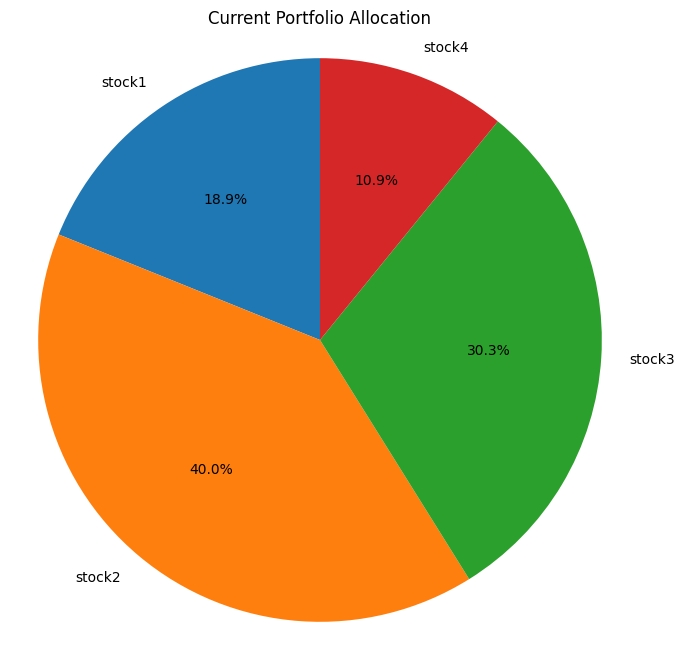

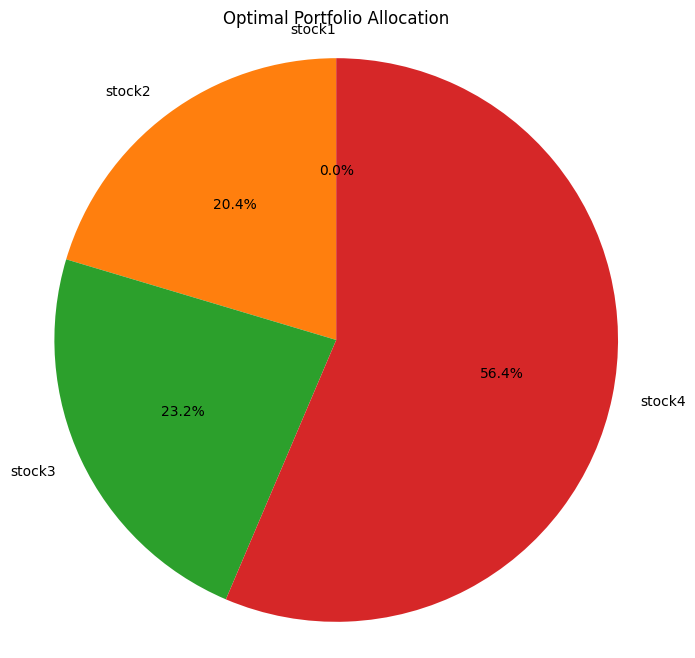

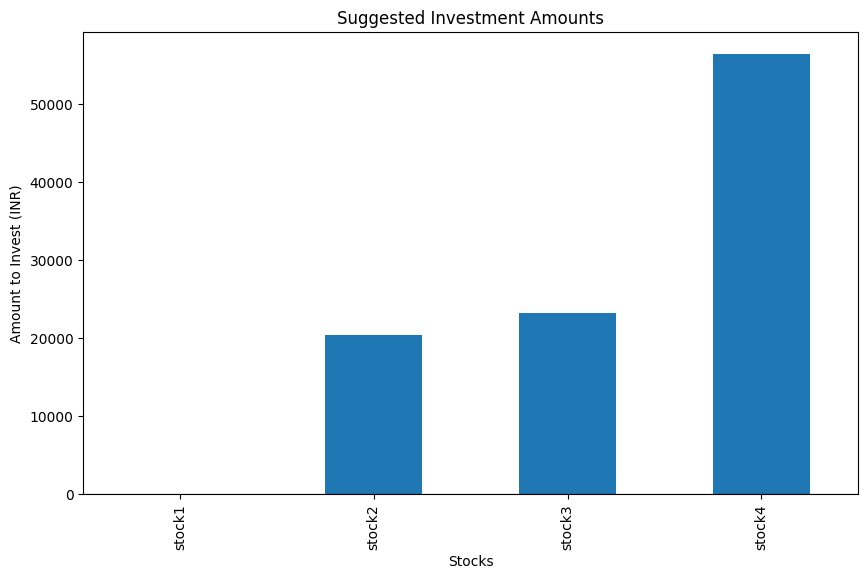


**Comparison Table:**
               Metric  Current Portfolio  Optimal Portfolio
Expected Daily Return           0.000226           0.000394
   Standard Deviation           0.005542           0.006443
         Sharpe Ratio           0.040769           0.061126


In [8]:

# Example data (replace with actual data in your app)
dates = pd.date_range(start='2023-01-01', periods=252, freq='B')  # 252 trading days
stocks = ['stock1', 'stock2', 'stock3', 'stock4']
np.random.seed(42)
# Generate price DataFrame
price_df = pd.DataFrame(
    np.random.randn(len(dates), len(stocks)).cumsum(axis=0) + 100,  # Cumulative sum along rows
    index=dates,
    columns=stocks
)

quantities = pd.Series({'stock1': 100, 'stock2': 200, 'stock3': 150, 'stock4': 50})
cash_to_invest = 100000  # Example: INR 100,000 to invest

# Step 1: Calculate daily returns
returns = price_df.pct_change().dropna()

# Step 2: Compute expected returns and covariance matrix
mean_returns = returns.mean()  # Expected daily returns
cov_matrix = returns.cov()    # Covariance of daily returns

# Step 3: Define portfolio performance function
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio return and standard deviation given weights.
    """
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std

# Step 4: Define negative Sharpe ratio function (to minimize)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    """
    Compute negative Sharpe ratio for optimization.
    """
    p_return, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_std

# Step 5: Optimize portfolio weights to maximize Sharpe ratio
num_assets = len(mean_returns)
args = (mean_returns, cov_matrix, 0)  # Risk-free rate = 0
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(num_assets))  # Weights between 0 and 1
initial_guess = num_assets * [1. / num_assets]  # Equal weights as initial guess

result = minimize(
    neg_sharpe_ratio,
    initial_guess,
    args=args,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
optimal_weights = result.x

# Step 6: Calculate current portfolio weights
latest_prices = price_df.iloc[-1]
current_values = quantities * latest_prices
total_value = current_values.sum()
current_weights = current_values / total_value

# Step 7: Compute current portfolio metrics
current_return, current_std = portfolio_performance(current_weights, mean_returns, cov_matrix)
current_sharpe = current_return / current_std

# Step 8: Compute optimal portfolio metrics
optimal_return, optimal_std = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
optimal_sharpe = optimal_return / optimal_std

# Step 9: Suggest how to allocate additional cash
# Allocate cash according to optimal weights to move portfolio closer to optimal
amount_to_buy = optimal_weights * cash_to_invest
suggested_trades = pd.Series(amount_to_buy, index=mean_returns.index)

# Step 10: Prepare output for the app
print("### Portfolio Analysis ###")
print("\n**Current Portfolio:**")
print(f"Expected Daily Return: {current_return:.6f}")
print(f"Standard Deviation (Risk): {current_std:.6f}")
print(f"Sharpe Ratio: {current_sharpe:.6f}")

print("\n**Optimal Portfolio:**")
print(f"Expected Daily Return: {optimal_return:.6f}")
print(f"Standard Deviation (Risk): {optimal_std:.6f}")
print(f"Sharpe Ratio: {optimal_sharpe:.6f}")

print("\n**Suggested Investments (INR):**")
for stock, amount in suggested_trades.items():
    if amount > 0:  # Only suggest buying, not selling
        print(f"{stock}: {amount:.2f}")

# Step 11: Visualizations

# Pie chart for current portfolio
plt.figure(figsize=(8, 8))
plt.pie(current_weights, labels=current_weights.index, autopct='%1.1f%%', startangle=90)
plt.title('Current Portfolio Allocation')
plt.axis('equal')
plt.show()

# Pie chart for optimal portfolio
plt.figure(figsize=(8, 8))
plt.pie(optimal_weights, labels=current_weights.index, autopct='%1.1f%%', startangle=90)
plt.title('Optimal Portfolio Allocation')
plt.axis('equal')
plt.show()

# Bar chart for suggested investments
plt.figure(figsize=(10, 6))
suggested_trades.plot(kind='bar')
plt.title('Suggested Investment Amounts')
plt.xlabel('Stocks')
plt.ylabel('Amount to Invest (INR)')
plt.axhline(0, color='black', linewidth=0.8)
plt.show()

# Optional: Comparison table for the app
comparison = pd.DataFrame({
    'Metric': ['Expected Daily Return', 'Standard Deviation', 'Sharpe Ratio'],
    'Current Portfolio': [current_return, current_std, current_sharpe],
    'Optimal Portfolio': [optimal_return, optimal_std, optimal_sharpe]
})
print("\n**Comparison Table:**")
print(comparison.to_string(index=False))

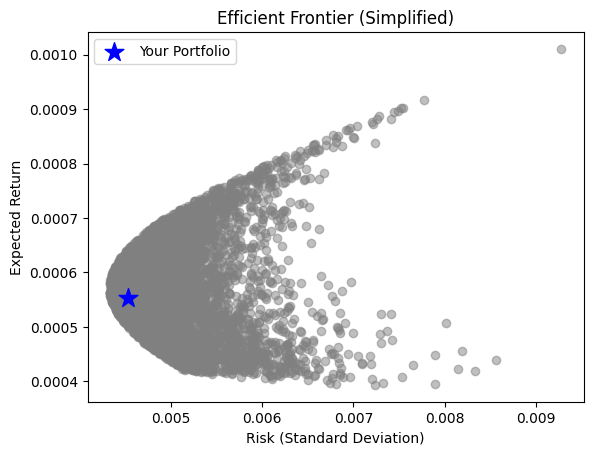

In [9]:


# Sample data: replace with your asset prices
dates = pd.date_range('2023-01-01', periods=252, freq='B')

# Generate price DataFrame
prices = pd.DataFrame(
    np.random.randn(len(dates), len(stocks)).cumsum(axis=0) + 100,  # Cumulative sum along rows
    index=dates,
    columns=stocks
)

returns = prices.pct_change().dropna()

# Expected returns and covariance
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Portfolio performance function
def portfolio_performance(weights):
    ret = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, risk

# Generate random portfolios
num_portfolios = 5000
results = np.zeros((2, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(4)
    weights /= weights.sum()
    ret, risk = portfolio_performance(weights)
    results[0, i] = ret
    results[1, i] = risk

# Your portfolio (example weights)
your_weights = np.array([0.3, 0.2, 0.4, 0.1])
your_ret, your_risk = portfolio_performance(your_weights)

# Plot
plt.scatter(results[1], results[0], c='gray', alpha=0.5)
plt.scatter(your_risk, your_ret, c='blue', marker='*', s=200, label='Your Portfolio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier (Simplified)')
plt.legend()
plt.show()

In [10]:
dates

DatetimeIndex(['2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05',
               '2023-01-06', '2023-01-09', '2023-01-10', '2023-01-11',
               '2023-01-12', '2023-01-13',
               ...
               '2023-12-06', '2023-12-07', '2023-12-08', '2023-12-11',
               '2023-12-12', '2023-12-13', '2023-12-14', '2023-12-15',
               '2023-12-18', '2023-12-19'],
              dtype='datetime64[ns]', length=252, freq='B')

In [11]:
stocks

['stock1', 'stock2', 'stock3', 'stock4']

In [12]:
price_df

,stock1,stock2,stock3,stock4
2023-01-02,100.496714,99.861736,100.647689,101.523030
2023-01-03,100.262561,99.627599,102.226901,102.290465
2023-01-04,99.793086,100.170159,101.763484,101.824735
2023-01-05,100.035049,98.256879,100.038566,101.262447
2023-01-06,99.022218,98.571126,99.130542,99.850144
...,...,...,...,...
2023-12-13,95.425569,103.573298,106.397321,113.707817
2023-12-14,95.178392,102.891313,105.395701,113.426717
2023-12-15,96.976078,103.532156,104.824522,113.999299
2023-12-18,98.375434,104.456790,104.884152,113.352363


In [13]:
output["price_history"]

,BBTC.NS,BALKRISIND.NS,HINDUNILVR.NS,TCS.NS,HDFCBANK.NS
2024-04-10,1590.795288,2409.177490,2230.204834,3927.766113,1515.653076
2024-04-11,1590.795288,2409.177490,2230.204834,3927.766113,1515.653076
2024-04-12,1593.693848,2383.283447,2201.993164,3944.276855,1498.487427
2024-04-13,1593.693848,2383.283447,2201.993164,3944.276855,1498.487427
2024-04-14,1593.693848,2383.283447,2201.993164,3944.276855,1498.487427
...,...,...,...,...,...
2025-04-06,2161.949951,2652.199951,2368.100098,4152.350098,1649.800049
2025-04-07,2161.949951,2652.199951,2368.100098,4152.350098,1649.800049
2025-04-08,2161.949951,2652.199951,2368.100098,4152.350098,1649.800049
2025-04-09,2161.949951,2652.199951,2368.100098,4152.350098,1649.800049


In [14]:
output["portfolio_consolidated"]

[['HDFCBANK.NS', [200, 288500.0, 1442.5, 329960.009765625]],
 ['HINDUNILVR.NS', [180, 409000.0, 2272.222222222222, 426258.017578125]],
 ['TCS.NS', [90, 285000.0, 3166.6666666666665, 373711.5087890625]],
 ['BBTC.NS', [10, 9000.0, 900.0, 21619.49951171875]],
 ['BALKRISIND.NS', [100, 136000.0, 1360.0, 265219.9951171875]]]

In [15]:
output["stock_quantity"]

[200, 180, 90, 10, 100]

In [16]:
quantities_mydata = pd.Series(dict(zip(output["portfolio_stock_names"], output["stock_quantity"])))

In [17]:
output["portfolio_stock_names"]

['HDFCBANK.NS', 'HINDUNILVR.NS', 'TCS.NS', 'BBTC.NS', 'BALKRISIND.NS']

In [18]:
quantities_mydata

HDFCBANK.NS      200
HINDUNILVR.NS    180
TCS.NS            90
BBTC.NS           10
BALKRISIND.NS    100
dtype: int64

In [19]:
quantities

stock1    100
stock2    200
stock3    150
stock4     50
dtype: int64

### Portfolio Analysis ###

**Current Portfolio:**
Expected Daily Return: 0.000401
Standard Deviation (Risk): 0.007502
Sharpe Ratio: 0.053469

**Optimal Portfolio:**
Expected Daily Return: 0.000459
Standard Deviation (Risk): 0.008169
Sharpe Ratio: 0.056136

**Suggested Investments (INR):**
BBTC.NS: 24004.43
BALKRISIND.NS: 8872.50
HINDUNILVR.NS: 36274.91
TCS.NS: 11879.70
HDFCBANK.NS: 18968.46


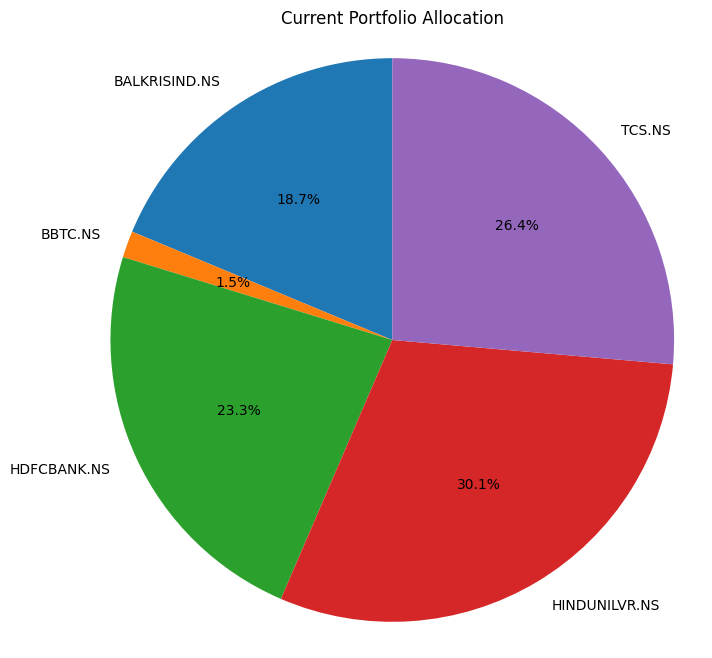

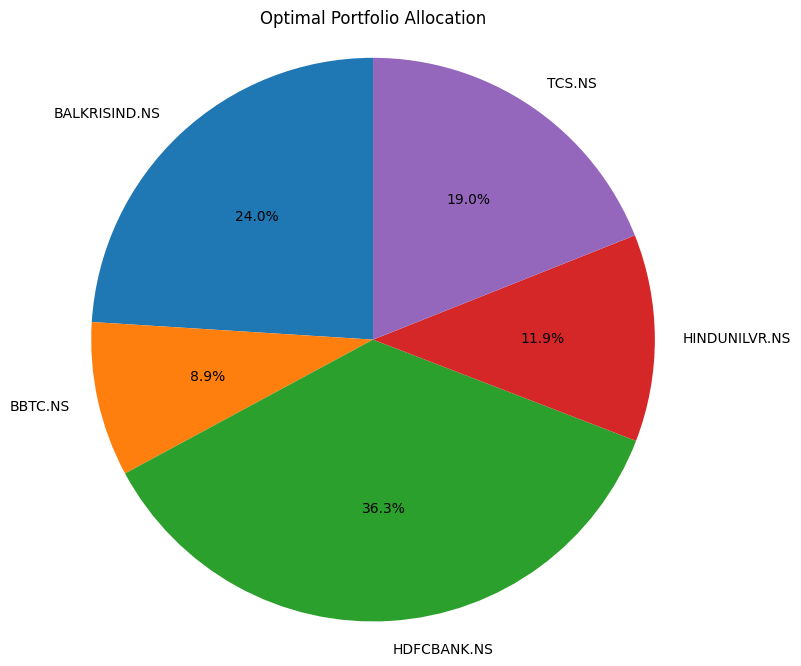

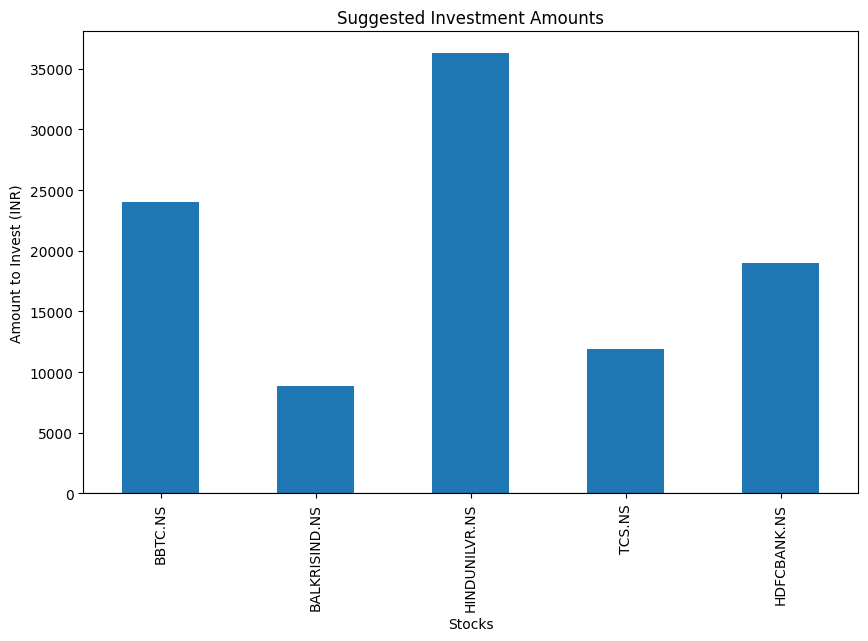


**Comparison Table:**
               Metric  Current Portfolio  Optimal Portfolio
Expected Daily Return           0.000401           0.000459
   Standard Deviation           0.007502           0.008169
         Sharpe Ratio           0.053469           0.056136


In [20]:

# Example data (replace with actual data in your app)

# Generate price DataFrame
price_df = output["price_history"]
quantities = pd.Series(dict(zip(output["portfolio_stock_names"], output["stock_quantity"])))

cash_to_invest = 100000  # Example: INR 100,000 to invest

# Step 1: Calculate daily returns
returns = price_df.pct_change().dropna()

# Step 2: Compute expected returns and covariance matrix
mean_returns = returns.mean()  # Expected daily returns
cov_matrix = returns.cov()    # Covariance of daily returns

# Step 3: Define portfolio performance function
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio return and standard deviation given weights.
    """
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std

# Step 4: Define negative Sharpe ratio function (to minimize)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    """
    Compute negative Sharpe ratio for optimization.
    """
    p_return, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_std

# Step 5: Optimize portfolio weights to maximize Sharpe ratio
num_assets = len(mean_returns)
args = (mean_returns, cov_matrix, 0)  # Risk-free rate = 0
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(num_assets))  # Weights between 0 and 1
initial_guess = num_assets * [1. / num_assets]  # Equal weights as initial guess

result = minimize(
    neg_sharpe_ratio,
    initial_guess,
    args=args,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
optimal_weights = result.x

# Step 6: Calculate current portfolio weights
latest_prices = price_df.iloc[-1]
current_values = quantities * latest_prices
total_value = current_values.sum()
current_weights = current_values / total_value

# Step 7: Compute current portfolio metrics
current_return, current_std = portfolio_performance(current_weights, mean_returns, cov_matrix)
current_sharpe = current_return / current_std

# Step 8: Compute optimal portfolio metrics
optimal_return, optimal_std = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
optimal_sharpe = optimal_return / optimal_std

# Step 9: Suggest how to allocate additional cash
# Allocate cash according to optimal weights to move portfolio closer to optimal
amount_to_buy = optimal_weights * cash_to_invest
suggested_trades = pd.Series(amount_to_buy, index=mean_returns.index)

# Step 10: Prepare output for the app
print("### Portfolio Analysis ###")
print("\n**Current Portfolio:**")
print(f"Expected Daily Return: {current_return:.6f}")
print(f"Standard Deviation (Risk): {current_std:.6f}")
print(f"Sharpe Ratio: {current_sharpe:.6f}")

print("\n**Optimal Portfolio:**")
print(f"Expected Daily Return: {optimal_return:.6f}")
print(f"Standard Deviation (Risk): {optimal_std:.6f}")
print(f"Sharpe Ratio: {optimal_sharpe:.6f}")

print("\n**Suggested Investments (INR):**")
for stock, amount in suggested_trades.items():
    if amount > 0:  # Only suggest buying, not selling
        print(f"{stock}: {amount:.2f}")

# Step 11: Visualizations

# Pie chart for current portfolio
plt.figure(figsize=(8, 8))
plt.pie(current_weights, labels=current_weights.index, autopct='%1.1f%%', startangle=90)
plt.title('Current Portfolio Allocation')
plt.axis('equal')
plt.show()

# Pie chart for optimal portfolio
plt.figure(figsize=(8, 8))
plt.pie(optimal_weights, labels=current_weights.index, autopct='%1.1f%%', startangle=90)
plt.title('Optimal Portfolio Allocation')
plt.axis('equal')
plt.show()

# Bar chart for suggested investments
plt.figure(figsize=(10, 6))
suggested_trades.plot(kind='bar')
plt.title('Suggested Investment Amounts')
plt.xlabel('Stocks')
plt.ylabel('Amount to Invest (INR)')
plt.axhline(0, color='black', linewidth=0.8)
plt.show()

# Optional: Comparison table for the app
comparison = pd.DataFrame({
    'Metric': ['Expected Daily Return', 'Standard Deviation', 'Sharpe Ratio'],
    'Current Portfolio': [current_return, current_std, current_sharpe],
    'Optimal Portfolio': [optimal_return, optimal_std, optimal_sharpe]
})
print("\n**Comparison Table:**")
print(comparison.to_string(index=False))

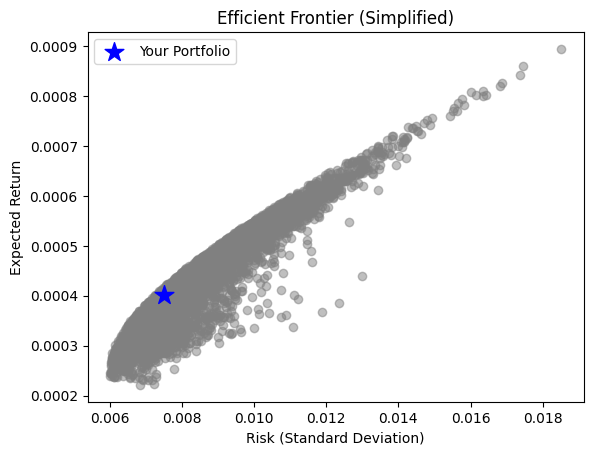

In [23]:



# Generate price DataFrame
prices = output["price_history"]


returns = prices.pct_change().dropna()

quantities = pd.Series(dict(zip(output["portfolio_stock_names"], output["stock_quantity"])))
# Step 6: Calculate current portfolio weights
latest_prices = prices.iloc[-1]
current_values = quantities * latest_prices
total_value = current_values.sum()
current_weights = current_values / total_value

# Expected returns and covariance
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Portfolio performance function
def portfolio_performance(weights):
    ret = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, risk

# Generate random portfolios
num_portfolios = 5000
results = np.zeros((2, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(5)
    weights /= weights.sum()
    ret, risk = portfolio_performance(weights)
    results[0, i] = ret
    results[1, i] = risk

# Your portfolio (example weights)
your_weights = current_weights
your_ret, your_risk = portfolio_performance(your_weights)

# Plot
plt.scatter(results[1], results[0], c='gray', alpha=0.5)
plt.scatter(your_risk, your_ret, c='blue', marker='*', s=200, label='Your Portfolio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier (Simplified)')
plt.legend()
plt.show()